### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [11]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
             }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

In [12]:
%%time
feat_shuffle_results_dict = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    params = params_fix.copy()
    print('params:', params)

    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
    
    for feat_name in ['none']+cols_feats:
        df_val_shuffle = df_val[cols_feats].copy()
        
        if feat_name != 'none':
            #if isinstance(df_val_shuffle[feat_name].dtype, pd.api.types.CategoricalDtype):
            dtype_col = df_val_shuffle[feat_name].dtype
            df_val_shuffle[feat_name] = np.random.permutation(df_val_shuffle[feat_name].values)
            df_val_shuffle[feat_name] = df_val_shuffle[feat_name].astype(dtype_col)
        
        y_pred = model.predict(df_val_shuffle)
        y_pred_final = target_inverse_transform(df_val_shuffle, y_pred)
        score = cal_score(df_val['total_price'], y_pred_final)
        print('%10.5f'%score, feat_name)

        feat_shuffle_results_dict[feat_name] = feat_shuffle_results_dict.get(feat_name, []) + [score]

# aggregate, sort gsearch results
feat_shuffle_results = [[key, np.mean(val), val] for key, val in feat_shuffle_results_dict.items()]
feat_shuffle_results.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00863764
[4000]	valid_0's mape: 0.00851461
[6000]	valid_0's mape: 0.00848378
[8000]	valid_0's mape: 0.00847272
[10000]	valid_0's mape: 0.00846802
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00846802
5554.86469 none
3925.79761 txn_dt
4638.84450 total_floor
3432.75589 building_complete_dt
5536.86434 parking_area
5002.84671 parking_price
3956.79925 txn_floor
2831.67577 land_area
1148.22874 building_area
5466.86158 lat
5146.85474 lon
4527.83779 village_income_median
5514.86397 town_population
5535.86459 town_area
5520.86372 town_population_density
4865.84824 doc_rate
5196.85782 master_rate
5490.86310 bachelor_rate
5145.85435 jobschool_rate
5532.86438 highschool_

5486.86404 XIII_1000
5210.85787 XIII_5000
3120.73592 XIII_10000
5504.86371 XIII_MIN
5501.86435 XIV_10
5498.86426 XIV_50
5508.86418 XIV_100
5489.86382 XIV_250
5496.86380 XIV_500
5480.86362 XIV_1000
5145.85569 XIV_5000
5492.86325 XIV_10000
5466.86363 XIV_MIN
5483.86292 building_material
5344.85941 city
4093.82606 building_type
5450.86293 building_use
5316.85971 parking_way
2390.68989 town
4765.84720 village
5502.86436 I_index_50
5502.86436 I_index_500
5504.86437 I_index_1000
5503.86436 II_index_50
5504.86436 II_index_500
5503.86437 II_index_1000
5503.86434 III_index_50
5502.86437 III_index_500
5503.86437 III_index_1000
5504.86437 IV_index_50
5502.86437 IV_index_500
5504.86435 IV_index_1000
5503.86437 IV_index_5000
5504.86435 V_index_50
5504.86437 V_index_500
5502.86434 V_index_1000
5503.86437 VI_10
5502.86437 VI_index_50
5505.86436 VI_index_500
5502.86437 VI_index_1000
5503.86435 VII_index_50
5502.86437 VII_index_500
5503.86437 VII_index_1000
5507.86437 VIII_index_50
5504.86436 VIII_inde

In [43]:
df_feat_shuffle_results = pd.DataFrame([row[0:2] + row[2] for row in feat_shuffle_results],
                                       columns=['col', 'mean', 'fold 1', 'fold 2', 'fold 3'])

In [46]:
df_feat_shuffle_results.head(20)

,col,mean,fold 1,fold 2,fold 3
0,XIII_index_500,5524.196631,5554.864688,5506.864367,5510.860839
1,VI_500,5524.196588,5552.864650,5506.864313,5512.860802
2,IX_index_50,5523.863285,5552.864675,5508.864342,5509.860837
3,I_50,5523.529967,5554.864683,5504.864368,5510.860848
4,III_index_50,5523.529932,5557.864660,5503.864344,5508.860792
5,XIV_100,5523.529795,5546.864540,5508.864178,5514.860668
6,X_50,5523.196638,5553.864689,5504.864377,5510.860846
7,VI_index_500,5523.196626,5556.864678,5505.864356,5506.860844
8,VIII_index_50,5523.196625,5552.864678,5507.864372,5508.860825
9,XI_index_1000,5523.196625,5555.864680,5504.864363,5508.860831


In [13]:
display(feat_shuffle_results)

[['XIII_index_500',
  5524.196631427719,
  [5554.864687671303, 5506.864367363557, 5510.860839248295]],
 ['VI_500',
  5524.196588360582,
  [5552.864650191094, 5506.864313036589, 5512.860801854061]],
 ['IX_index_50',
  5523.863284797632,
  [5552.864675432365, 5508.864341825125, 5509.860837135405]],
 ['I_50',
  5523.529966556772,
  [5554.864683260135, 5504.864367975401, 5510.860848434779]],
 ['III_index_50',
  5523.52993208159,
  [5557.864659971765, 5503.864344404302, 5508.860791868703]],
 ['XIV_100',
  5523.529795207054,
  [5546.864539653806, 5508.864178449932, 5514.860667517423]],
 ['X_50',
  5523.196637563681,
  [5553.864689312683, 5504.864377317361, 5510.860846060999]],
 ['VI_index_500',
  5523.196626105514,
  [5556.8646782603455, 5505.864355730731, 5506.860844325468]],
 ['VIII_index_50',
  5523.19662525478,
  [5552.864677874489, 5507.864372420937, 5508.860825468915]],
 ['XI_index_1000',
  5523.196624752728,
  [5555.864680395527, 5504.8643628123455, 5508.860831050311]],
 ['XIII_250',


In [36]:
scores_feat_rank = [row [1] for row in feat_shuffle_results if row[0] != 'none']

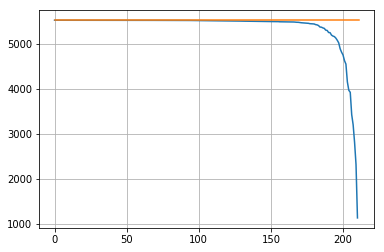

In [37]:
plt.plot(scores_feat_rank) # list(range(len(scores_feat_rank)))
plt.plot([0, len(scores_feat_rank)], [5522.529969962893, 5522.529969962893])
#plt.xscale('log')
plt.grid()
plt.show()

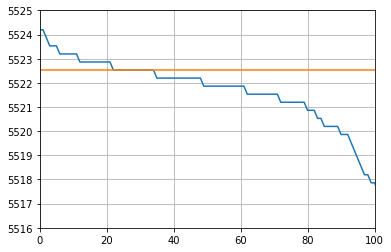

In [57]:
plt.plot(scores_feat_rank) # list(range(len(scores_feat_rank)))
plt.plot([0, len(scores_feat_rank)], [5522.529969962893, 5522.529969962893])
plt.xlim(0, 100)
plt.ylim(5516, 5525)
#plt.xscale('log')
plt.grid()
plt.show()

## Feature remove

### Feature remove list 1
Remove feature with shuffle scores >= non-shuffle score

In [50]:
none_score = df_feat_shuffle_results.loc[df_feat_shuffle_results['col'] == 'none', 'mean'].values[0]
none_score

5522.529969962893

In [52]:
feat_rm_1 = df_feat_shuffle_results.loc[df_feat_shuffle_results['mean'] > none_score, 'col'].tolist()

In [59]:
print(len(feat_rm_1))
print('feat_rm_1 =', feat_rm_1)

23
feat_rm_1 = ['XIII_index_500', 'VI_500', 'IX_index_50', 'I_50', 'III_index_50', 'XIV_100', 'X_50', 'VI_index_500', 'VIII_index_50', 'XI_index_1000', 'XIII_250', 'N_500', 'XIII_index_50', 'I_index_1000', 'I_10', 'IV_index_1000', 'VIII_index_1000', 'IX_index_1000', 'I_index_50', 'XIII_10', 'X_index_50', 'IX_50', 'VI_10']


### Feature remove list 2
Remove feature with shuffle scores last 50

In [60]:
feat_rm_2 = [c for c in df_feat_shuffle_results['col'].tolist()[:51] if c != 'none']

In [62]:
print(len(feat_rm_2))
print('feat_rm_2 =', feat_rm_2)

50
feat_rm_2 = ['XIII_index_500', 'VI_500', 'IX_index_50', 'I_50', 'III_index_50', 'XIV_100', 'X_50', 'VI_index_500', 'VIII_index_50', 'XI_index_1000', 'XIII_250', 'N_500', 'XIII_index_50', 'I_index_1000', 'I_10', 'IV_index_1000', 'VIII_index_1000', 'IX_index_1000', 'I_index_50', 'XIII_10', 'X_index_50', 'IX_50', 'VI_10', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'IV_index_5000', 'II_index_1000', 'VII_index_1000', 'XI_index_5000', 'XIII_index_5000', 'II_index_500', 'X_100', 'IX_100', 'XII_index_50', 'XIV_index_500', 'IV_index_50', 'XII_index_500', 'VI_index_50', 'N_5000', 'XIII_100', 'IX_10', 'XIII_index_10000', 'II_index_50', 'XI_index_500', 'V_index_1000', 'VII_index_50', 'VIII_50', 'XIV_10']


### Feature remove list 3
Remove feature with shuffle scores last 100

In [63]:
feat_rm_3 = [c for c in df_feat_shuffle_results['col'].tolist()[:101] if c != 'none']

In [64]:
print(len(feat_rm_3))
print('feat_rm_3 =', feat_rm_3)

100
feat_rm_3 = ['XIII_index_500', 'VI_500', 'IX_index_50', 'I_50', 'III_index_50', 'XIV_100', 'X_50', 'VI_index_500', 'VIII_index_50', 'XI_index_1000', 'XIII_250', 'N_500', 'XIII_index_50', 'I_index_1000', 'I_10', 'IV_index_1000', 'VIII_index_1000', 'IX_index_1000', 'I_index_50', 'XIII_10', 'X_index_50', 'IX_50', 'VI_10', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'IV_index_5000', 'II_index_1000', 'VII_index_1000', 'XI_index_5000', 'XIII_index_5000', 'II_index_500', 'X_100', 'IX_100', 'XII_index_50', 'XIV_index_500', 'IV_index_50', 'XII_index_500', 'VI_index_50', 'N_5000', 'XIII_100', 'IX_10', 'XIII_index_10000', 'II_index_50', 'XI_index_500', 'V_index_1000', 'VII_index_50', 'VIII_50', 'XIV_10', 'X_10', 'XI_10', 'VI_50', 'III_index_1000', 'XIII_index_1000', 'II_10', 'V_index_500', 'I_100', 'IV_index_500', 'VIII_index_500', 'X_index_500', 'VI_1000', 'VI_index_1000', 'VII_index_500', 'XIV_index_50', 'III_index_500', 'IV_10', 'V_index_50', 'XI_50', 'III_10', '

### Feature shuffle importance 

In [67]:
feat_rank_list = [c for c in df_feat_shuffle_results['col'].tolist() if c != 'none'];
print('feat_rank_list =', feat_rank_list)  # List of least important features

feat_rank_list = ['XIII_index_500', 'VI_500', 'IX_index_50', 'I_50', 'III_index_50', 'XIV_100', 'X_50', 'VI_index_500', 'VIII_index_50', 'XI_index_1000', 'XIII_250', 'N_500', 'XIII_index_50', 'I_index_1000', 'I_10', 'IV_index_1000', 'VIII_index_1000', 'IX_index_1000', 'I_index_50', 'XIII_10', 'X_index_50', 'IX_50', 'VI_10', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'IV_index_5000', 'II_index_1000', 'VII_index_1000', 'XI_index_5000', 'XIII_index_5000', 'II_index_500', 'X_100', 'IX_100', 'XII_index_50', 'XIV_index_500', 'IV_index_50', 'XII_index_500', 'VI_index_50', 'N_5000', 'XIII_100', 'IX_10', 'XIII_index_10000', 'II_index_50', 'XI_index_500', 'V_index_1000', 'VII_index_50', 'VIII_50', 'XIV_10', 'X_10', 'XI_10', 'VI_50', 'III_index_1000', 'XIII_index_1000', 'II_10', 'V_index_500', 'I_100', 'IV_index_500', 'VIII_index_500', 'X_index_500', 'VI_1000', 'VI_index_1000', 'VII_index_500', 'XIV_index_50', 'III_index_500', 'IV_10', 'V_index_50', 'XI_50', 'III_10', 